# Actor determination method 3: Based on operations
This notebook depicts the third methodology for actor determination as described in the corresponding master thesis. Known operations are used as a measure to determine active threat actors. The actors will be ranked based on the date of the first operation, in order to detect whether an actor has just started, and the number of operations. These operations are weighted using an inverse weighting method, ranking recent operations higher. A graphical representation is depicted in the image below.

The enriched data can then be filtered on the sector and the actors and TTPs will be ranked using the ranking functions. These ranked TTPs are then mapped to controls in order to obtain a prioritization of security controls. 

This notebook includes code for experiments on TTP subset sizes to be used in control prioritization. 

![Diagram representation of method 3](./docs/images/Method3.png)

Options for control frameworks are:

- ISO_2013_CIS
- ISO_2013_CIS7
- ISO_2013_NIST
- ISO_2022
- NIST_SP_800_53
- NIST_CSF
- CIS_v8


## 1. Determine active actors
### 1.0. Settings

In [170]:
SECTOR = 'Education'
CONTROLS = "ISO_2022"
YEAR = 2023
INTERVAL = 1



MOTIVATION = "Information theft and espionage"
COUNTRY = "Netherlands"

FILTER_MOTIVATION = False
FILTER_COUNTRY = False
TTP_THRESHOLD = 0

### 1.1. Read ETDA and MITRE data

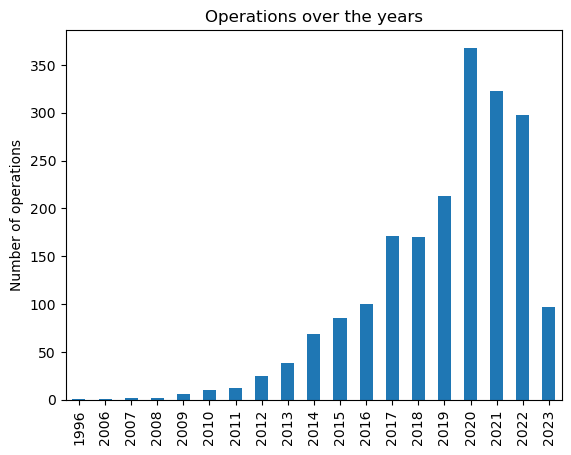

In [171]:
import pandas as pd
import matplotlib.pyplot as plt

merge_df = pd.read_json('data/ETDA_ATTCK_merge.json',encoding='utf-8')
# df = pd.DataFrame(merge_list)
merge_df['etda_operation_year'].explode().value_counts().sort_index().plot(kind='bar',title="Operations over the years",ylabel="Number of operations")
plt.savefig("results/figures/method3/operations_graph.pdf",format="pdf", bbox_inches="tight")

In [172]:
ops_year = merge_df.explode('etda_operation_year')#['etda_name'].value_counts()
ops_year = ops_year.loc[ops_year['etda_operation_year'] == '2021']
ops_year['etda_name'].value_counts()

Wizard Spider, Gold Blackburn           31
APT 29, Cozy Bear, The Dukes            28
Pinchy Spider, Gold Southfield          24
Carbanak, Anunak                        21
FIN11                                   15
                                        ..
Bahamut                                  1
Gallium                                  1
SideCopy                                 1
Winnti Group, Blackfly, Wicked Panda     1
Bitter                                   1
Name: etda_name, Length: 80, dtype: int64

#### 1.2. Preprocessing

In [173]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list if len(x) > 1]) # Convert column of lists to one list and remove single character values

agg_dict = {}
for column in merge_df.columns:
    if column == 'mitre_attack_ttps':
        agg_dict[column] = 'sum'
    else:
        agg_dict[column] = 'first'

merge_df = merge_df.groupby(['etda_name']).agg(agg_dict)
merge_df['mitre_attack_ttps'] = merge_df['mitre_attack_ttps'].apply(lambda x: pd.Series(x).unique())

C:\Users\Abe\AppData\Local\Temp\ipykernel_2732\773326629.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  merge_df['mitre_attack_ttps'] = merge_df['mitre_attack_ttps'].apply(lambda x: pd.Series(x).unique())


#### Define filter functions

In [174]:
def filter_by_sector(df, sector):
    df['sector_filter'] = df['victim_industries'].map(lambda x: [i for i in x if i == sector])
    return df.loc[df['sector_filter'].map(bool)]

def filter_by_sectors(df, sectors):
    actors_sector_exploded = df.explode('victim_industries')
    return actors_sector_exploded.loc[actors_sector_exploded['victim_industries'] in sectors]

def filter_by_operation_year(df, interval):
    years = list(range((YEAR-interval),YEAR+1))
    years = [str(i) for i in years]
    df['etda_operation_year'] = df['etda_operation_year'].apply(lambda x: [i for i in x if i in years])
    return df

def filter_by_motivation(df, motivation):
    df['motivation_filter'] = df['motivation'].map(lambda x: [i for i in x if i == motivation])
    return df.loc[df['motivation_filter'].map(bool)]

def filter_by_target_country(df,country):
    df['victim_countries_filter'] = df['victim_countries'].map(lambda x: [i for i in x if i == country])
    return df.loc[df['victim_countries_filter'].map(bool)]

#### 1.3. Filter on sector

<Axes: title={'center': 'Operations within Education sector over the years'}>

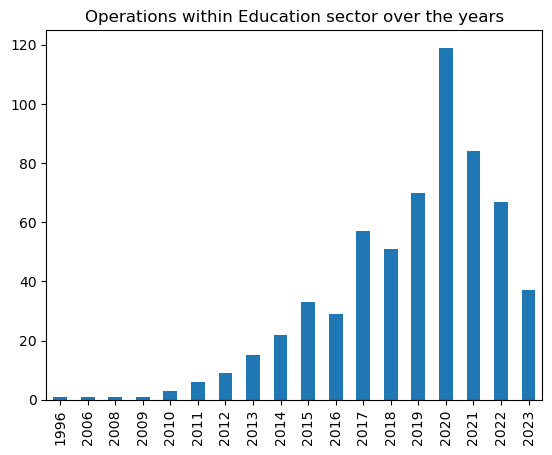

In [175]:
actors_filtered = filter_by_sector(merge_df, SECTOR)
actors_filtered = actors_filtered.drop('sector_filter',axis=1)
actors_filtered['etda_operation_year'].explode().value_counts().sort_index().plot(kind='bar',title="Operations within {} sector over the years".format(SECTOR))

#### Observation
How is the date derived? Date of reported breach, or date of actual breach.

Are reports relevant? 

#### 1.4. Count number of recent operations
Remove actors with no operations

In [176]:
import numpy as np

def filter_by_operation_year(df, interval):
    years = list(range((YEAR-interval),YEAR+1))
    years = [str(i) for i in years]
    df['etda_operation_year'] = df['etda_operation_year'].apply(lambda x: [i for i in x if i in years])
    return df



actors_filtered = filter_by_operation_year(actors_filtered, INTERVAL)    
actors_filtered['ops_count'] = actors_filtered['etda_operation_year'].apply(len)
actors_filtered = actors_filtered.loc[actors_filtered['ops_count']>0].sort_values(by='ops_count',ascending=False)

print("Number of actors in time frame and sector:",actors_filtered.shape[0])

# actors_filtered['ops_weight'].nlargest(5).plot(kind='barh',x='etda_name',xlabel='Actor',ylabel='Number of registered operations',title="Top 5 actors targeting {} sector.\nBased on operations between {} and {}".format(SECTOR,YEAR-INTERVAL,YEAR))
# actors_filtered['weight'].nlargest(5).plot(kind='barh',x='etda_name',xlabel='Actor',ylabel='Number of registered operations',title="Top 5 actors targeting {} sector.\nBased on operations between {} and {}".format(SECTOR,YEAR-INTERVAL,YEAR))

Number of actors in time frame and sector: 25


In [177]:
if FILTER_MOTIVATION:
    actors_filtered = filter_by_motivation(actors_filtered, MOTIVATION)
    actors_filtered = actors_filtered.drop('motivation_filter',axis=1)

if FILTER_COUNTRY:
    actors_filtered = filter_by_target_country(actors_filtered, COUNTRY)
    actors_filtered = actors_filtered.drop('victim_countries_filter',axis=1)

In [178]:
actors_filtered['victim_countries'].explode().value_counts()

USA              20
UK               14
Thailand         13
Australia        12
Germany          12
                 ..
Mauritius         1
None Provided     1
Sri Lanka         1
Malta             1
Zimbabwe          1
Name: victim_countries, Length: 126, dtype: int64

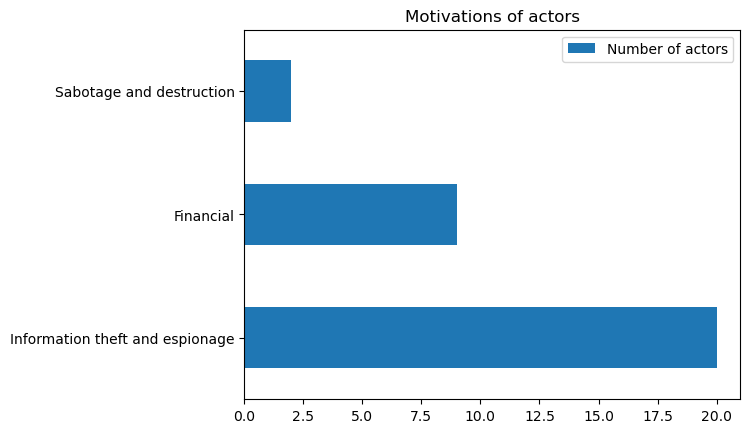

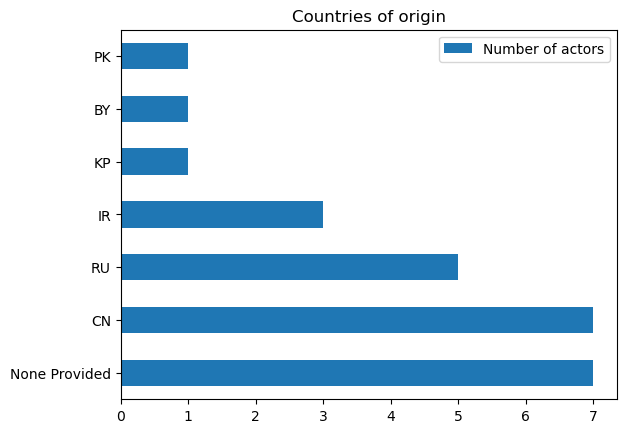

In [179]:
fig, ax = plt.subplots()
actors_filtered['motivation'].explode().replace(to_replace=['Financial gain','Financial crime'],value='Financial').value_counts().plot(kind='barh',title='Motivations of actors')
ax.legend(['Number of actors'])
plt.show()

fig, ax = plt.subplots()
actors_filtered['country'].value_counts().plot(kind='barh',title='Countries of origin',rot=0)
# labels = [item.get_text() for item in ax.get_yticklabels()]
# labels_new = ['China','Russia','Unknown','Iran','North Korea','India','Belarus','Pakistan','South Korea','Colombia']
# ax.set_yticklabels(labels_new)
ax.legend(['Number of actors'])
plt.show()
# labels

#### Filter on motivation and country

#### Show distribution of operations

<Axes: title={'center': 'Operations in data between 2022 and 2023 by\n actors targeting Education sector'}>

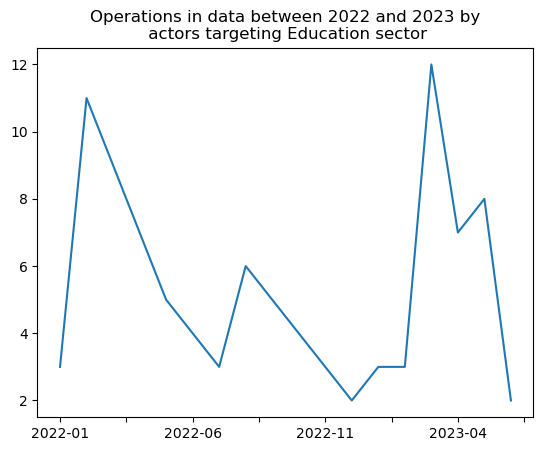

In [180]:
years = map(str,list(range((YEAR-INTERVAL),YEAR+1)))
ops_timeframe = actors_filtered.explode('etda_operation_dates')
ops_timeframe = ops_timeframe[ops_timeframe['etda_operation_dates'].str.contains('|'.join(years))]
ops_timeframe = ops_timeframe[ops_timeframe['etda_operation_dates'].str.contains('-')]
ops_timeframe['etda_operation_dates'].value_counts().sort_index().plot(title="Operations in data between {} and {} by\n actors targeting {} sector".format(YEAR-INTERVAL,YEAR,SECTOR))


## 2. Rank actors and TTPs
### 2.1 Rank actors
#### 2.1.1 Create weight and sort

In [181]:
def inverse_square_root(x):
    return 1/np.sqrt(YEAR - int(x) + 1)

def inverse(x):
    # return 1/np.exp2(YEAR - int(x) + 1)
    return 1/(YEAR - int(x) + 1)


actors_filtered['buzz'] = 1/np.sqrt(YEAR - actors_filtered['etda_first_seen'].apply(int) + 1)
actors_filtered['ops_weight'] = actors_filtered['etda_operation_year'].apply(lambda x: sum([inverse(i) for i in x]))
actors_filtered['weight'] = actors_filtered['ops_weight'] * actors_filtered['buzz']

actors_filtered[['etda_first_seen','buzz','ops_count','ops_weight','weight']].sort_values(by='weight',ascending=False)

,etda_first_seen,buzz,ops_count,ops_weight,weight
etda_name,,,,,
FIN11,2016,0.353553,14,12.0,4.242641
"Kimsuky, Velvet Chollima",2012,0.288675,13,11.5,3.319764
"Mustang Panda, Bronze President",2012,0.288675,13,9.0,2.598076
Operation Ghostwriter,2017,0.377964,8,4.0,1.511858
"Sandworm Team, Iron Viking, Voodoo Bear",2009,0.258199,7,4.5,1.161895
"APT 29, Cozy Bear, The Dukes",2008,0.250000,7,4.5,1.125000
"MuddyWater, Seedworm, TEMP.Zagros, Static Kitten",2017,0.377964,3,2.5,0.944911
"Transparent Tribe, APT 36",2013,0.301511,5,3.0,0.904534
"Sofacy, APT 28, Fancy Bear, Sednit",2004,0.223607,6,3.5,0.782624


In [182]:
def normalize(df):
    return (df-df.min())/(df.max()-df.min())

actors_filtered['actor_weight'] = normalize(actors_filtered['weight'])

actors_filtered.sort_values(by='actor_weight',ascending=False,inplace=True)

actors_ranked = actors_filtered[['actor_weight','mitre_attack_ttps']]
unique_ttps = to_1D(actors_ranked['mitre_attack_ttps']).value_counts()

print('Number of actors:',actors_ranked.index.size)
print('Number of TTPs:\t', unique_ttps.index.size)

Number of actors: 25
Number of TTPs:	 263


<Axes: title={'center': 'Top 5 actors targeting Education sector based on operations between 2022 and 2023 (normalized)'}, xlabel='Actor Name', ylabel='etda_name'>

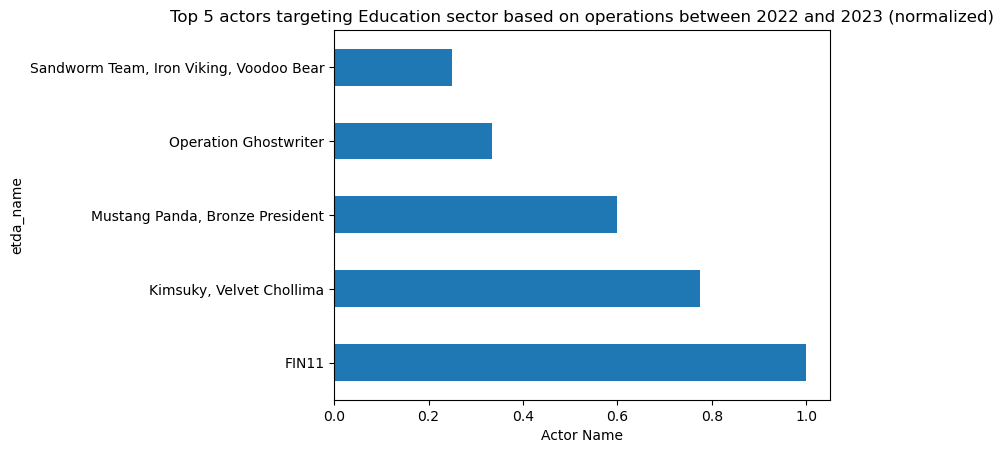

In [183]:
actor_weights = actors_ranked['actor_weight']
actor_weights.nlargest(5).plot(kind='barh',xlabel='Actor Name', title="Top 5 actors targeting {} sector based on operations between {} and {} (normalized)".format(SECTOR,YEAR-INTERVAL,YEAR))

In [184]:
actors_filtered.columns

Index(['mitre_attack_id', 'mitre_attack_name', 'mitre_attack_aliases',
       'mitre_attack_created', 'mitre_attack_last_modified', 'mitre_url',
       'etda_id', 'etda_name', 'etda_aliases', 'etda_first_seen', 'etda_url',
       'etda_operation_dates', 'etda_operation_year', 'country', 'motivation',
       'victim_industries', 'victim_countries', 'mitre_attack_ttps',
       'ops_count', 'buzz', 'ops_weight', 'weight', 'actor_weight'],
      dtype='object')

#### Observations
Since the Government sector is the most represented in the ETDA dataset, this one is chosen for the tests. 13 of the actors from the reports target this sector. APT 29 is mentioned the most across reports. This is due to their notorious SolarWinds attack in 2020, which is mentioned often. In 2021 they also launched a big spear-phishing campaign. This actor is followed by Wizard Spider, a ransomware actor that is very active.

It is mainly these two actors that exceed the others in terms of how often they are mentioned. The other mentioned actors have a weigth just below 1.0.

### 2.2. Rank TTPs
#### 2.3.1 Explode dataframe per TTP
Explode the dataframe per TTP. Now a weighting calculation can be done per TTP, based on the information provided. Information includes the actor results (and kill chain phase).

For now: the actor weights are summed per TTP to obtain a ranking per TTP. 

In [185]:
actors_ranked['number_of_actors'] = 1
actors_ttp_exploded = actors_ranked.explode('mitre_attack_ttps')

C:\Users\Abe\AppData\Local\Temp\ipykernel_2732\823944124.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actors_ranked['number_of_actors'] = 1


#### 2.3.2. Group by TTP and sum actor weights
Sum the actor weights.

In [186]:
actors_ttp_summed = actors_ttp_exploded.reset_index(drop=True)
ttps_ranked = actors_ttp_summed.groupby('mitre_attack_ttps').sum()
print(ttps_ranked.sort_values(by='actor_weight',ascending=False))

                   actor_weight  number_of_actors
mitre_attack_ttps                                
T1566.001              2.709606                13
T1204.002              2.671873                12
T1204.001              2.629604                11
T1566.002              2.629604                11
T1059.001              2.584062                13
...                         ...               ...
T1102.001              0.037733                 1
T1135                  0.037733                 1
T1568.002              0.037733                 1
T1197                  0.037733                 1
T1218.007              0.000000                 1

[263 rows x 2 columns]


#### 2.3.3 Enrich TTP information
Information from the ATT&CK data is used via the attackcti package.

In [187]:
from attackcti import attack_client
from pandas import json_normalize
import sys

mitre_columns = ['technique_id','technique','tactic','technique_detection']

def get_attck_dataframe(matrix = 'enterprise'):
    if  (matrix.lower() == 'enterprise'):
        # Instantiating attack_client class
        lift = attack_client()
        # Getting techniques for windows platform - enterprise matrix
        attck = lift.get_enterprise_techniques(stix_format = False)
        # Generating a dataframe with information collected
        attck = json_normalize(attck)
        return attck
    else:
        sys.exit('ERROR: Only Enterprise available!!')

attck = get_attck_dataframe()
attck = attck[mitre_columns]

ttps_enriched = pd.merge(ttps_ranked,attck,how='left',left_index=True,right_on='technique_id')
ttps_enriched.index = ttps_ranked.index
ttps_enriched['technique_name_id'] = ttps_enriched['technique'] + " (" + ttps_enriched['technique_id'] + ")"


[taxii2client.v20] [WARNING ] [2023-08-16 22:11:55,333] TAXII Server Response did not include 'Content-Range' header - results could be incomplete.
[taxii2client.v20] [WARNING ] [2023-08-16 22:11:55,502] TAXII Server Response with different amount of objects! Setting per_request=750


#### 2.3.4. Calculate weights

In [188]:
ttps_enriched['ttp_weight'] = normalize(ttps_enriched['actor_weight'])
ttps_enriched = ttps_enriched.drop(['actor_weight','technique_id'],axis=1)
ttps_enriched

,number_of_actors,technique,tactic,technique_detection,technique_name_id,ttp_weight
mitre_attack_ttps,,,,,,
Not Available,10,NaN,NaN,NaN,NaN,0.667851
T1001.001,1,Junk Data,[command-and-control],Analyze network data for uncommon data flows (...,Junk Data (T1001.001),0.058290
T1003,1,OS Credential Dumping,[credential-access],### Windows\nMonitor for unexpected processes ...,OS Credential Dumping (T1003),0.058290
T1003.001,7,LSASS Memory,[credential-access],Monitor for unexpected processes interacting w...,LSASS Memory (T1003.001),0.590214
T1003.002,1,Security Account Manager,[credential-access],Hash dumpers open the Security Accounts Manage...,Security Account Manager (T1003.002),0.036007
...,...,...,...,...,...,...
T1608.004,2,Drive-by Target,[resource-development],If infrastructure or patterns in the malicious...,Drive-by Target (T1608.004),0.105247
T1615,1,Group Policy Discovery,[discovery],System and network discovery techniques normal...,Group Policy Discovery (T1615),0.021945
T1621,1,Multi-Factor Authentication Request Generation,[credential-access],Monitor user account logs as well as 2FA/MFA a...,Multi-Factor Authentication Request Generation...,0.089041


#### Statistics

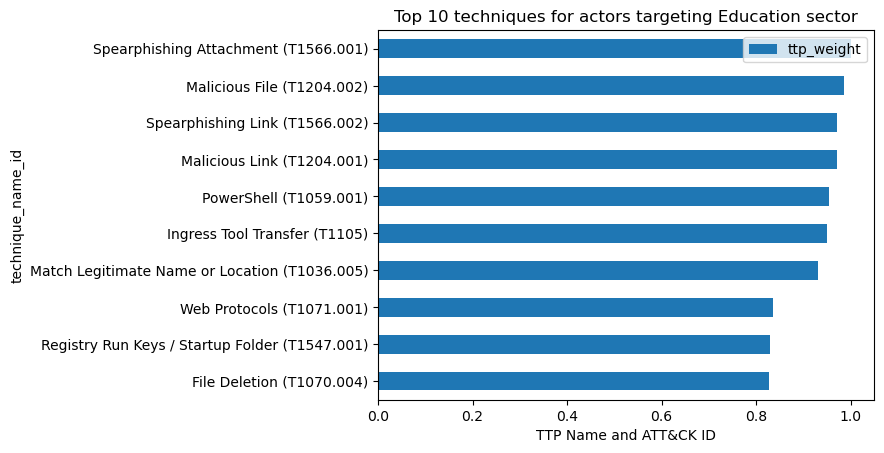

In [189]:
ttps_enriched.nlargest(10,columns='ttp_weight').sort_values('ttp_weight').plot.barh(y='ttp_weight',x='technique_name_id',xlabel="TTP Name and ATT&CK ID" ,title="Top 10 techniques for actors targeting {} sector".format(SECTOR))

# ttps_enriched.plot.hist(column="number_of_actors",bins=10, title="Distribution of TTP weights for actors targeting {} sector".format(SECTOR))
ttps_enriched = ttps_enriched.drop(['number_of_actors','technique_name_id'],axis=1)

Only take the top percentage of the TTPs

In [190]:
PERCENTAGE = 1
ttp_mean = ttps_enriched['ttp_weight'].median()
print("TTP Mean:",ttp_mean)

TTP_THRESHOLD = ttp_mean

def take_percentage(percentage,df):
    top_percent = int(len(df) * PERCENTAGE)
    print("Taking {}%; {} entries".format(percentage*100,top_percent))
    return df.nlargest(top_percent,columns="ttp_weight")

def take_threshold(threshold, df):
    return df.loc[df['ttp_weight']>threshold]

# ttps_enriched = take_percentage(PERCENTAGE,ttps_enriched)
# ttps_enriched = take_threshold(TTP_THRESHOLD,ttps_enriched)
ttps_enriched.sort_values(by="ttp_weight",inplace=True,ascending=False)

TTP Mean: 0.1282260239517578


#### Observations
Within the tested Government sector, the top 10 techniques used are shown above. 
The top technique is '[Obfuscated Files or Information](https://attack.mitre.org/techniques/T1027/)', where adversaries obfuscate the contents of an executable or file by encrypting, encoding, compressing or otherwise obscuring them on the system or in transit. This is common behavior to evade defenses. 

The second technique is '[Tool](https://attack.mitre.org/techniques/T1588/002/)', is described as "Adversaries may buy, steal or download software tools that can be used during targeting." This is a very generic technique, since the use of the use of tools is common among hackers and there exists a wide variety of tools, hence why it is listed in such a high position.

## 3. Control prioritization

### 3.1 Control Mapping
Source of the mapping: [Security Control Framework Mappings to ATT&CK](https://github.com/center-for-threat-informed-defense/attack-control-framework-mappings).

This maps controls from NIST 800-53 to MITRE ATT&CK. The following versions are considered:
- MITRE ATT&CK v10.1
- NIST 800-53 Revision 5

In [191]:
# Load ATT&CK to NIST 800-53 mapping
def get_nist_sp800_53_attck_mapping():
    nist_attck_mapping = pd.read_excel("data/mappings/nist800-53-r5-mappings-attckv12.xlsx")
    nist_attck_mapping = nist_attck_mapping.drop(["Mapping Type","Technique Name"],axis=1)
    return nist_attck_mapping

def get_nist_csf_attck_mapping():
    nist_attck_mapping = pd.read_excel("data/mappings/NIST_CSF_ATTCKv12.xlsx")
    return nist_attck_mapping

def get_cis_attck_mapping():
    cis_attck_mapping = pd.read_excel("data/mappings/CIS_Controls_v8_ATTCKv82_condensed.xlsx")
    cis_attck_mapping = cis_attck_mapping.drop(["CIS Controls v8","CIS Controls","Asset Type"],axis=1)
    cis_attck_mapping['Technique ID'] = cis_attck_mapping['Technique ID'].str.split(', ')
    cis_attck_mapping.drop('Description',axis=1)
    return cis_attck_mapping.explode('Technique ID')

def get_iso_attck_mapping():
    iso_attck_mapping = pd.read_excel("data/mappings/ISO_27001_2022_ATTCKv82.xlsx")
    return iso_attck_mapping

def get_nist_iso_2013_attck_mapping():
    iso_attck_mapping = pd.read_excel("data/mappings/ISO_27001_2013_ATTCKv10.1_FROM_NIST.xlsx")
    return iso_attck_mapping

def get_cis_iso_2013_attck_mapping():
    iso_attck_mapping = pd.read_excel("data/mappings/ISO_27001_2013_ATTCKv82.xlsx")
    return iso_attck_mapping

def get_cis7_iso_2013_attck_mapping():
    iso_attck_mapping = pd.read_excel("data/mappings/ISO_27001_2013_ATTCKv82_FROM_CIS7.xlsx")
    return iso_attck_mapping

Merge the TTPs with the controls based on the selected framework. Remove controls which are expired.

In [192]:
ttp_control_map = get_iso_attck_mapping()
if CONTROLS == "ISO_2013_CIS":
    ttp_control_map = get_cis_iso_2013_attck_mapping()
elif CONTROLS == "ISO_2013_CIS7":
    ttp_control_map = get_cis7_iso_2013_attck_mapping()
elif CONTROLS == "ISO_2013_NIST":
    ttp_control_map = get_nist_iso_2013_attck_mapping()
elif CONTROLS == "ISO_2022":
    ttp_control_map = get_iso_attck_mapping()
elif CONTROLS == "NIST_SP_800_53":
    ttp_control_map = get_nist_sp800_53_attck_mapping()
elif CONTROLS == "NIST_CSF":
    ttp_control_map = get_nist_csf_attck_mapping()
elif CONTROLS == "CIS_v8":
    ttp_control_map = get_cis_attck_mapping()

ttp_control_merge = ttp_control_map.merge(ttps_enriched, left_on="Technique ID", right_on="mitre_attack_ttps",how="inner")
ttp_control_merge = ttp_control_merge.loc[ttp_control_merge["Control ID"] != '/']
ttp_control_merge = ttp_control_merge.loc[ttp_control_merge["Control ID"] != 'None']
ttp_control_merge = ttp_control_merge.loc[ttp_control_merge["Control Name"] != 'Vervallen']

ttp_control_merge.sort_values(by='ttp_weight',inplace=True,ascending=False)
print("Number of TTPS:",ttp_control_merge['Technique ID'].value_counts().index.size)
print("Number of controls:",ttp_control_merge['Control ID'].value_counts().index.size)


Number of TTPS: 163
Number of controls: 42


Get TTPs incl number of controls that mitigate them

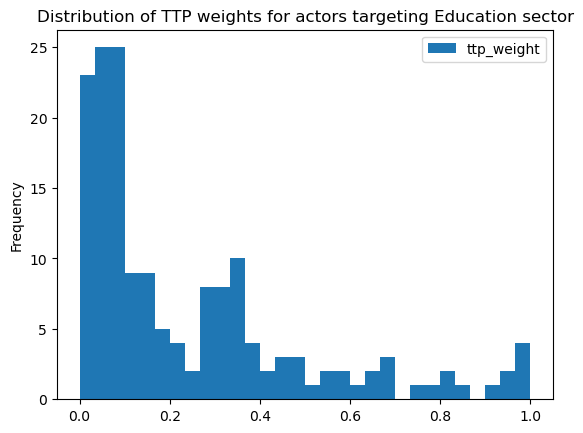

In [193]:
ttp_control_merge[['Technique ID','ttp_weight']].drop_duplicates().plot(kind='hist',bins=30,title="Distribution of TTP weights for actors targeting {} sector".format(SECTOR))
# ttp_control_merge['ttp_weight'].plot(kind='hist',bins=30,title="Distribution of TTP weights for actors targeting {} sector".format(SECTOR),xlabel="TTP weights")
plt.savefig("results/figures/method3/ttp_distribution_{}_{}-{}.pdf".format(SECTOR, (YEAR-INTERVAL),YEAR),format="pdf", bbox_inches="tight")

**Observations**

The TTP weights are a normalised summation of the actor weights. This means, the higher the TTP weight, the more (high weighted) actors share this TTP.
We can see that the distribution of TTP weights is a right-skewed distribution. This is expected, since this means that the number of TTPs that are shared by these actors is 

C:\Users\Abe\AppData\Local\Temp\ipykernel_2732\2613384342.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ttp_control_ranked = ttp_control_merge.groupby(['Control ID','Control Name']).sum()


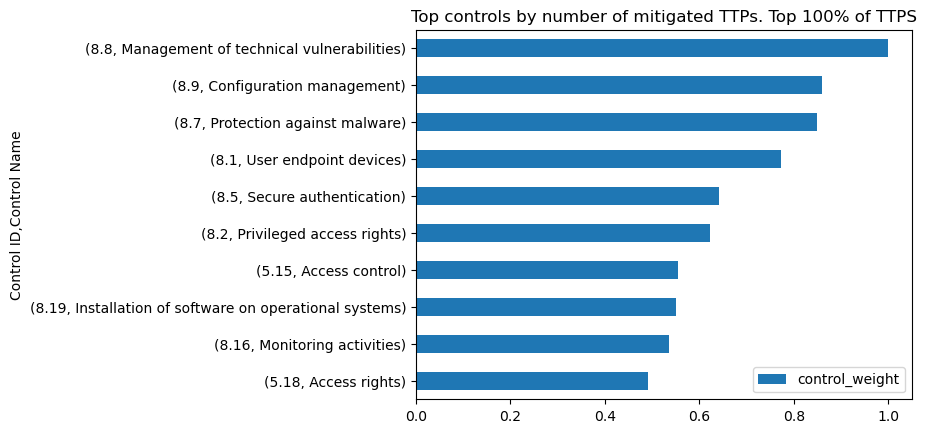

In [194]:
# ttp_control_merge[['Control ID','Control Name']].value_counts().nlargest(10).plot(kind='barh',title="Number of selected TTPs mitigated per control")

ttp_control_ranked = ttp_control_merge.groupby(['Control ID','Control Name']).sum()
ttp_control_ranked.rename(columns={'ttp_weight':'control_weight'},inplace=True)
ttp_control_ranked['control_weight'] = normalize(ttp_control_ranked['control_weight'])
ttp_control_ranked.sort_values(by='control_weight',ascending=False, inplace=True)

# ttp_control_ranked.nlargest(10,columns='ttp_weight').plot(kind='barh',title="Top controls by number of mitigated TTPs. No TTP threshold")
ttp_control_ranked.nlargest(10,columns='control_weight').sort_values('control_weight').plot(kind='barh',title="Top controls by number of mitigated TTPs. Top {}% of TTPS".format(PERCENTAGE*100))
ttp_control_ranked.reset_index(level=1,inplace=True)

#### Observations
There are some controls that map to a lot of TTPs. For the complete results for the ‘Government’ sector, there are 215 TTPs and 106 controls. Merging the two gives a resulting set of 2545 mappings. Since there is no measure of control effectiveness to a TTP in this data, they are sorted based on the TTPs they control and their respective weights.

There are two ways to approach the control mapping, either a generic approach or a targeted approach.
- Targeted: Take the most prominent TTPs, those with the highest weights, and display the controls for this. 
- Generic: Take the complete, or near-complete, set of TTPs used by the actors. Rank the controls based on the number of TTPs they control and their respective weights. The downside of this is that controls that map to a large number of TTPs will probably always end up on top. This means that the initial TTP ranking matters less.

When simply counting the number of TTPs that a control covers, only the general ones come to the top. Even if the TTP weights are considered. One possibility to solve this, is to only take the top x% of TTPs into consideration.

# Get TTPs mitigated by said control

In [195]:
control_id = "A.13.1.1"
ttp_control_merge.loc[ttp_control_merge['Control ID'] == control_id]

,Control ID,Technique ID,Control Name,technique,tactic,technique_detection,ttp_weight


# Export results
Export the results to an excel with three sheets:
- Actors
- TTPs
- Controls

In [196]:
writer = pd.ExcelWriter("results/Result Sheet {} for {} sector between {}-{}.xlsx".format(CONTROLS,SECTOR,YEAR-INTERVAL,YEAR),engine="xlsxwriter")

ttp_control_ranked.to_excel(writer,sheet_name="Controls")
ttp_control_merge.to_excel(writer,sheet_name="TTP and Control mitigations",index=False)
ttps_enriched.to_excel(writer,sheet_name="TTPs")
actors_filtered[['etda_url','country','motivation','victim_industries','victim_countries','etda_first_seen','buzz','ops_count','ops_weight','weight','actor_weight']].to_excel(writer,sheet_name="Actors")

writer.close()